# 题目: 构建和使用长短时记忆神经网络（LSTM） - 使用 airline-passengers 数据集

在这个教程中，我们将介绍如何使用 Pytorch 构建和训练一个长短时记忆神经网络（LSTM）模型，然后使用该模型预测未来的乘客数量。我们将使用 [airline-passengers 数据集](https://www.kaggle.com/rakannimer/air-passengers)。

## 1. 加载数据

使用 pandas 加载数据集，并通过 matplotlib 可视化数据。

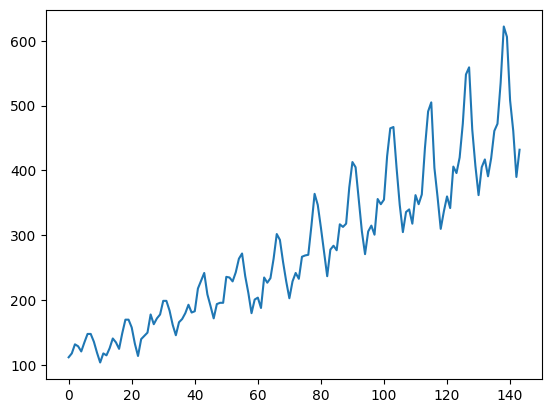

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')

plt.plot(timeseries)
plt.show()

* 时序数据归一化

对于时序数据，归一化对模型性能的影响至关重要。我们将使用 MinMaxScaler 对时序数据进行归一化，以便更好地训练 LSTM 模型。

In [2]:
from sklearn.preprocessing import MinMaxScaler

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
timeseries = scaler.fit_transform(timeseries)

## 2. 划分训练集和测试集

我们将数据集划分为训练集和测试集。我们将使用前三分之二的数据作为训练集，剩余的数据作为测试集。

注意：对时序数据而言，划分训练集和测试集时，不能随机划分。我们需要确保训练集中的数据是按时间顺序排列的，以防止模型在训练时“看到”未来的数据。

In [3]:
# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

* 创建 Dataset

对于训练集和测试集中的数据，我们采用步长为 lookback 的时间窗口，去预测下一时刻的目标值，以此构建样本。

In [4]:
import torch
import numpy as np

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset[i : i + lookback, 0]  # 从i到i+lookback，共lookback个数据
        target = dataset[i + lookback, 0]  # 第i+lookback个数据
        X.append(feature)
        y.append(target)
    X, y = np.array(X), np.array(y)  # X.shape: (samples, lookback), y.shape: (samples,)
    X = X.reshape(X.shape[0], X.shape[1], 1)  # shape: (samples, lookback, features)，添加一个维度，LSTM 需要接受三维输入
    return torch.tensor(X), torch.tensor(y)

In [5]:
lookback = 5
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([91, 5, 1]) torch.Size([91])
torch.Size([43, 5, 1]) torch.Size([43])


In [6]:
from torch.utils.data import DataLoader, Dataset

class AirDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return len(self.X)

## 3. 构建模型

我们将构建一个包含两个 LSTM 层和一个全连接层的模型。

* LSTM 层的参数

    * input_size: 输入特征的数量
    * hidden_size: 隐藏层的大小
    * num_layers: LSTM 层的数量
    * batch_first: 如果为 True，则输入和输出张量的形状为 (batch_size, sequence_length, input_size)，否则输入和输出张量的形状为 (sequence_length, batch_size, input_size)
    * dropout: dropout 概率（要求 num_layers > 1）
    * bidirectional: 是否使用双向 LSTM（输出维度将变为 hidden_size * 2）

* 我们采用 batch_first 策略，LSTM 层接受的数据格式为 (batch_size, sequence_length, input_size)

* LSTM 层的输出是一个元祖，包含了输出张量和最后一个时间步的 hidden state 和 cell state

* 我们将最后一个 LSTM 层的最后一个时间步的输出传递给全连接层，以预测下一个时间步的乘客数量。

In [7]:
import torch.nn as nn

class AirModel(nn.Module):
    def __init__(self):
        super(AirModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size=1,
                            hidden_size=8,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.lstm2 = nn.LSTM(input_size=16,
                            hidden_size=32,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=False)
        self.linear = nn.Linear(32, 1)
    def forward(self, x):  # x.shape: (batch, lookback, 1)
        x, _ = self.lstm1(x)  # x.shape: (batch, lookback, 16)
        x, _ = self.lstm2(x)  # x.shape: (batch, lookback, 32)
        # extract only the last time step
        x = x[:, -1, :]  # x.shape: (batch, 32)
        x = self.linear(x)  # x.shape: (batch, 1)
        return x

## 4. 训练模型

In [8]:
device = "cpu"

model = AirModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # 时序数据通常使用 Adam 优化器
loss_fn = nn.MSELoss()
train_dataset = AirDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=8)

n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        loss = loss_fn(y_pred.flatten(), y_batch)  # 计算 MSE 损失, y_pred 的尺寸是 (batch, 1), y_batch 的尺寸是 (batch,)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train)
            train_rmse = np.sqrt(loss_fn(y_pred.flatten(), y_train))  # 计算 RMSE 损失, y_pred 的尺寸是 (samples, 1), y_train 的尺寸是 (samples,)
            y_pred = model(X_test)
            test_rmse = np.sqrt(loss_fn(y_pred.flatten(), y_test))
        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 0.1327, test RMSE 0.4246
Epoch 10: train RMSE 0.0607, test RMSE 0.1539
Epoch 20: train RMSE 0.0502, test RMSE 0.1479
Epoch 30: train RMSE 0.0454, test RMSE 0.0997
Epoch 40: train RMSE 0.0420, test RMSE 0.1078
Epoch 50: train RMSE 0.0514, test RMSE 0.1024
Epoch 60: train RMSE 0.0396, test RMSE 0.1082
Epoch 70: train RMSE 0.0437, test RMSE 0.1076
Epoch 80: train RMSE 0.0384, test RMSE 0.1071
Epoch 90: train RMSE 0.0396, test RMSE 0.1053


## 5. 模型预测结果可视化

思考：时序预测模型的预测结果通常会表现出相对于真实值的滞后性，思考其中的原因？

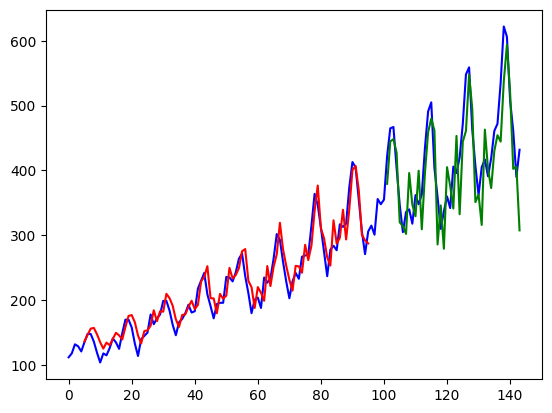

In [9]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred_train = model(X_train)
    y_pred_train = scaler.inverse_transform(y_pred_train)  # 反归一化
    train_plot[lookback:train_size] = y_pred_train
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    y_pred_test = model(X_test)
    y_pred_test = scaler.inverse_transform(y_pred_test)  # 反归一化
    test_plot[train_size+lookback:len(timeseries)] = y_pred_test

plt.plot(scaler.inverse_transform(timeseries), c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

# 作业

#### 构建简单的LSTM网络模型，使用德里市每日气候数据集进行训练和测试。介绍所构建的模型，并报告在测试集上的准确率。

daily-climate: https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data

德里市每日气候数据集任务：使用当天及以前（0~t时刻）的湿度、气压、风速三个指标预测当天（t时刻）的温度，最后报告测试集上温度值的均方误差MSE。

In [2]:
pip install kagglehub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 57.1 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


直接采用的动漫头像网站上推荐的下载方式直接利用库用数据集，没有手动下载

In [ ]:
# train_anime_dcgan_tuned.py
import os
import random
from pathlib import Path
from typing import List

import kagglehub
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image

# ========== 将命令行参数改为直接定义 ==========
class Args:
    def __init__(self):
        self.batch_size = 256
        self.workers = min(32, os.cpu_count() or 8)
        self.image_size = 64
        self.nz = 100
        self.ngf = 64
        self.ndf = 64
        self.nc = 3
        self.g_lr = 0.0001
        self.d_lr = 0.0002
        self.beta1 = 0.5
        self.epochs = 120
        self.output_dir = "outputs_tuned"
        self.seed = None
        self.log_interval = 100
        self.sample_count = 64
        self.save_every = 10
        self.d_steps = 2
        self.real_label = 0.9

# 使用定义好的参数
args = Args()

# ========== 以下是原有的类定义 ==========
class ImageFileDataset(Dataset):
    def __init__(self, root: Path, transform: transforms.Compose):
        self.root = root
        self.transform = transform
        self.paths: List[Path] = []
        for ext in ("*.png", "*.jpg", "*.jpeg", "*.bmp"):
            self.paths.extend(root.rglob(ext))
        self.paths = sorted(self.paths)
        if not self.paths:
            raise RuntimeError(f"No image files found under {root}")

    def __len__(self) -> int:
        return len(self.paths)

    def __getitem__(self, idx: int):
        path = self.paths[idx]
        with Image.open(path) as img:
            img = img.convert("RGB")
        return self.transform(img)

def resolve_dataset_dir(download_dir: Path) -> Path:
    if (download_dir / "images").is_dir():
        return download_dir / "images"
    return download_dir

def weights_init(module):
    classname = module.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(module.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(module.weight.data, 1.0, 0.02)
        nn.init.constant_(module.bias.data, 0)

class Generator(nn.Module):
    def __init__(self, nz: int, ngf: int, nc: int):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        return self.main(z)

class Discriminator(nn.Module):
    def __init__(self, nc: int, ndf: int):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.main(x).view(-1)

def train(args):
    if args.seed is None:
        args.seed = random.randint(1, 10000)
    print(f"Using seed: {args.seed}")
    random.seed(args.seed)
    torch.manual_seed(args.seed)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    if device.type == "cuda":
        torch.backends.cudnn.benchmark = True

    print("Downloading dataset via kagglehub...")
    download_path = Path(kagglehub.dataset_download("splcher/animefacedataset"))
    dataset_dir = resolve_dataset_dir(download_path)
    print(f"Dataset directory: {dataset_dir}")

    transform = transforms.Compose([
        transforms.Resize(args.image_size),
        transforms.CenterCrop(args.image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    dataset = ImageFileDataset(dataset_dir, transform)
    dataloader = DataLoader(
        dataset,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=args.workers,
        pin_memory=device.type == "cuda",
        drop_last=True,
    )

    netG = Generator(args.nz, args.ngf, args.nc).to(device)
    netD = Discriminator(args.nc, args.ndf).to(device)
    netG.apply(weights_init)
    netD.apply(weights_init)

    criterion = nn.BCELoss()
    fixed_noise = torch.randn(args.sample_count, args.nz, 1, 1, device=device)
    real_label = args.real_label
    fake_label = 0.0

    optimizerD = optim.Adam(netD.parameters(), lr=args.d_lr, betas=(args.beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=args.g_lr, betas=(args.beta1, 0.999))

    output_dir = Path(args.output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    print("Starting training...")
    total_iters = 0
    for epoch in range(args.epochs):
        for i, real in enumerate(dataloader):
            for _ in range(args.d_steps):
                netD.zero_grad()
                real_batch = real.to(device)
                b_size = real_batch.size(0)
                label = torch.full((b_size,), real_label, device=device)
                output = netD(real_batch)
                errD_real = criterion(output, label)
                errD_real.backward()
                D_x = output.mean().item()

                noise = torch.randn(b_size, args.nz, 1, 1, device=device)
                fake = netG(noise)
                label.fill_(fake_label)
                output_fake = netD(fake.detach())
                errD_fake = criterion(output_fake, label)
                errD_fake.backward()
                D_G_z1 = output_fake.mean().item()
                errD = errD_real + errD_fake
                optimizerD.step()

            netG.zero_grad()
            label.fill_(real_label)
            output = netD(fake)
            errG = criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()

            if total_iters % args.log_interval == 0:
                print(
                    f"[Epoch {epoch+1}/{args.epochs}] [Batch {i+1}/{len(dataloader)}] "
                    f"Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} "
                    f"D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}"
                )

            total_iters += 1

        should_save = (epoch + 1) % args.save_every == 0 or (epoch + 1) == args.epochs
        if should_save:
            with torch.no_grad():
                fake_samples = netG(fixed_noise).detach().cpu()
            grid = make_grid(fake_samples, padding=2, normalize=True)
            sample_path = output_dir / f"samples_epoch_{epoch+1:03d}.png"
            save_image(grid, sample_path)

            checkpoint_path = output_dir / f"checkpoint_epoch_{epoch+1:03d}.pt"
            torch.save({
                "epoch": epoch + 1,
                "netG": netG.state_dict(),
                "netD": netD.state_dict(),
                "optimizerG": optimizerG.state_dict(),
                "optimizerD": optimizerD.state_dict(),
                "args": vars(args),
            }, checkpoint_path)
            print(f"Saved checkpoint and sample at epoch {epoch+1}")

    final_gen_path = output_dir / "generator_final.pt"
    torch.save(netG.state_dict(), final_gen_path)
    print(f"Training complete. Final generator saved to {final_gen_path}")

# ========== 直接调用训练函数 ==========
if __name__ == "__main__":
    # 直接使用定义好的参数
    train(args)

Using seed: 92
Using device: cpu


  5%|▍         | 18.0M/395M [06:40<2:37:20, 41.8kB/s]

部分输出：
[Epoch 499/500] [Batch 97/248] Loss_D: 0.3332 Loss_G: 6.3268 D(x): 0.8714 D(G(z)): 0.0011/0.0015
[Epoch 499/500] [Batch 197/248] Loss_D: 0.3314 Loss_G: 5.6605 D(x): 0.8985 D(G(z)): 0.0041/0.0032
[Epoch 500/500] [Batch 49/248] Loss_D: 0.3340 Loss_G: 6.0777 D(x): 0.8678 D(G(z)): 0.0016/0.0022
[Epoch 500/500] [Batch 149/248] Loss_D: 0.3444 Loss_G: 5.3921 D(x): 0.8410 D(G(z)): 0.0022/0.0043
Saved checkpoint and sample at epoch 500
Training complete. Final generator saved to outputs_tuned/generator_final.pt

得到结果可见文件夹下图片，分别是epoch为200和500的结果samples，相对应的权重可见.pt 文件，训练过程终端输出可见log文件。从图片中可见200轮时已经有较好的结果，增加轮次结果并没有显著变好。